In [51]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

In [52]:
df = pd.read_csv("RegresiUTSTelkom.csv", header=None)
num_cols = len(df.columns)
new_cols = ['target'] + ['x' + str(i) for i in range(1, num_cols)]
df.columns = new_cols
print("\nDataset Info:")
print(df.info())
print(f"\nMissing values: {df.isnull().sum().sum()}")


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515345 entries, 0 to 515344
Data columns (total 91 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   target  515345 non-null  int64  
 1   x1      515345 non-null  float64
 2   x2      515345 non-null  float64
 3   x3      515345 non-null  float64
 4   x4      515345 non-null  float64
 5   x5      515345 non-null  float64
 6   x6      515345 non-null  float64
 7   x7      515345 non-null  float64
 8   x8      515345 non-null  float64
 9   x9      515345 non-null  float64
 10  x10     515345 non-null  float64
 11  x11     515345 non-null  float64
 12  x12     515345 non-null  float64
 13  x13     515345 non-null  float64
 14  x14     515345 non-null  float64
 15  x15     515345 non-null  float64
 16  x16     515345 non-null  float64
 17  x17     515345 non-null  float64
 18  x18     515345 non-null  float64
 19  x19     515345 non-null  float64
 20  x20     515345 non-null  float64


In [53]:
def clean_data(df):
    for col in df.columns:
        if df[col].dtype == "object":
            df[col].fillna(df[col].mode()[0], inplace=True)
        else:
            df[col].fillna(df[col].median(), inplace=True)
    df.drop_duplicates(inplace=True)
    numeric_cols = df.select_dtypes(include=["number"]).columns
    for col in numeric_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df
df = clean_data(df)

In [55]:
categorical_cols = df.select_dtypes(include=["object"]).columns
numerical_cols = df.select_dtypes(include=["number"]).columns.drop("target")

df_encoded = pd.get_dummies(df, columns=categorical_cols)
scaler = StandardScaler()
df_encoded[numerical_cols] = scaler.fit_transform(df_encoded[numerical_cols])

X = df_encoded.drop("target", axis=1).values
y = df_encoded["target"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [57]:
class BasicMLP(nn.Module):
    def __init__(self, input_dim):
        super(BasicMLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        return self.model(x)

# === Training Setup ===
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

model = BasicMLP(input_dim=X_train.shape[1])
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [58]:
epochs = 100
losses = []
model.train()
for epoch in range(epochs):
    epoch_loss = 0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        output = model(batch_X)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    losses.append(epoch_loss / len(train_loader))
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss = {losses[-1]:.4f}")


Epoch 0: Loss = 3748204.4995
Epoch 10: Loss = 246260.4086
Epoch 20: Loss = 49521.1139
Epoch 30: Loss = 4996.0159
Epoch 40: Loss = 419.2951
Epoch 50: Loss = 67.4546
Epoch 60: Loss = 46.2568
Epoch 70: Loss = 43.4062
Epoch 80: Loss = 42.7763
Epoch 90: Loss = 41.9929


In [61]:
model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor).numpy().flatten()
    actuals = y_test_tensor.numpy().flatten()

mse = mean_squared_error(actuals, predictions)
rmse = np.sqrt(mean_squared_error(actuals, predictions))
r2 = r2_score(actuals, predictions)

print(f"\nEvaluation Metrics:")
print(f"MSE : {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R^2 : {r2:.4f}")


Evaluation Metrics:
MSE : 44.4850
RMSE: 6.6697
R^2 : 0.2797


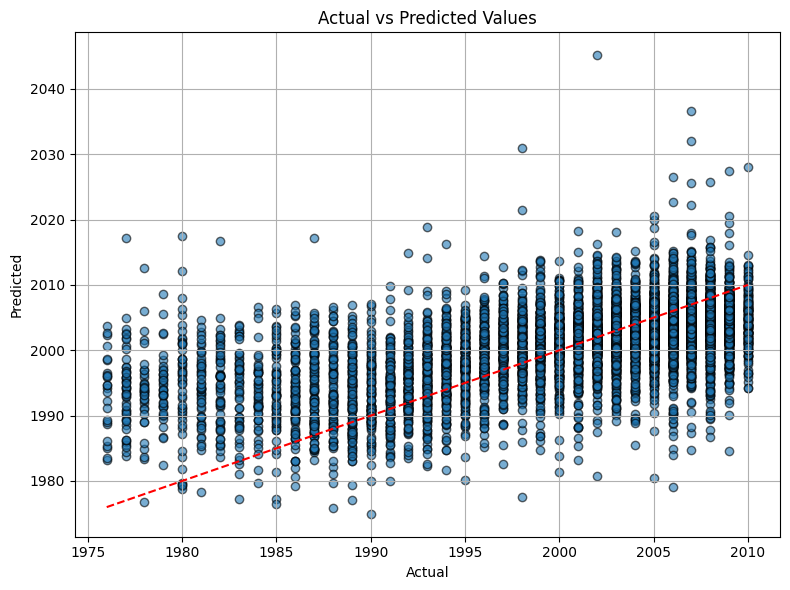

In [62]:
plt.figure(figsize=(8, 6))
plt.scatter(actuals, predictions, alpha=0.6, edgecolors='k')
plt.plot([actuals.min(), actuals.max()], [actuals.min(), actuals.max()], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted Values")
plt.grid(True)
plt.tight_layout()
plt.show()

# Kesimpulan

1. Preprocessing
- Data Cleaning menghandle missing value deengan mengisi kolom object dengan modus dan kolom numerik dengan median
- data duplikat dihapus
- Outlier dibuang menggunakan metode IQR
- Feature Engineering: One-Hot Encoding semua fitur kategorikal
- Train-Test Split: Dibagi 80% train set dan 20% test set

2. Model: MLP (Multi layer Perceptron) - PyTorch
- Hidden layer 64 neuron dengan aktivasi ReLU
- Outpuet layer: 1 neuron
- Optimizer Adam
- Loss function: MSELoss
- Training: 100 epoch, batch size 64

3. Hasil Evaluasi
- Scatter plot menunjukkan banyak titik menyebar jauh dari garis merah, mengindikasikan prediksi tidak akurat.
